# 线性回归模型，自定义损失函数

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


(20640, 8)
(20640,)


In [3]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test=train_test_split(housing.data, housing.target,random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

In [4]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)
x_valid_scaled = transfer.transform(x_valid)

In [6]:
#函数式API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1=keras.layers.Dense(30,activation='relu')(input)
hidden2=keras.layers.Dense(30,activation='relu')(hidden1)

cancat = keras.layers.concatenate([input, hidden2])#用concatenate把两个层连接起来
output = keras.layers.Dense(1)(cancat)

model = keras.models.Model(input, output)
def customized_mse(y_ture,y_pred):
    '''自定义均方差损失函数'''
    return tf.reduce_mean(tf.square(y_pred-y_ture))



model.compile(loss=customized_mse,#'使用自定义的mean_squared_error',
             optimizer = 'nadam',# SGD -> SGDM -> NAG ->AdaGrad -> AdaDelta -> Adam -> Nadam
              metrics=['mean_squared_error']#放入内置的损失函数mse做对比
             )


In [8]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = model.fit(x_train_scaled,y_train,epochs=3,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks )

Train on 11610 samples, validate on 3870 samples
Epoch 1/3
11610/11610 [==============================] - 5s 463us/sample - loss: 1.2338 - mean_squared_error: 1.2338 - val_loss: 0.5437 - val_mean_squared_error: 0.5437
Epoch 2/3
11610/11610 [==============================] - 2s 199us/sample - loss: 0.4459 - mean_squared_error: 0.4459 - val_loss: 0.4331 - val_mean_squared_error: 0.4331
Epoch 3/3
11610/11610 [==============================] - 2s 200us/sample - loss: 0.3974 - mean_squared_error: 0.3974 - val_loss: 0.3967 - val_mean_squared_error: 0.3967


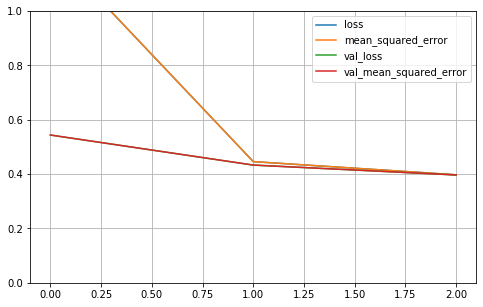

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [ ]:
# model.evaluate(x_test_scaled,y_test，verbose=2)
#sklearn_model没有evaluate函数

In [ ]:
from scipy.stats import reciprocal
param_distribution={
    'hidden_layers': [1,2,3,4,5,],
    'layer_size': np.arange(1,100),
    'learnning_rate': reciprocal(1e-4,1e-2)
    }
from sklearn.model_selection import RandomizedSearchCV
estimator = RandomizedSearchCV(sklearn_model, #模型estimator
                                                 param_distribution,#定义好的搜索空间
                                                 n_iter = 10,#要搜索的参数集合数量
#                                                  n_jobs = 1，#并行处理数据数量
                                                  )

callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
estimator.fit(x_train_scaled,y_train,epochs=100,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks)

In [ ]:
# reciprocal函数演示
# from scipy.stats import reciprocal
# # f(x) = 1/(x*log(b/a))     a<x<b
# reciprocal.rvs(1e-4, 1e-2, size =10)

In [ ]:
#最佳参数
print('最佳参数：\n',estimator.best_params_)
#最佳结果
print('最佳结果:\n',estimator.best_score_)
#最佳估计器
print('最佳估计器：\n',estimator.best_estimator_)
#交叉验证结果
# print('交叉验证结果:\n',estimator.cv_results_)

In [ ]:
model = estimator.best_estimator_.model
model.evaluate(x_test_scaled, y_test)